# Results

- Best Model parameters : StackingRegressor {'final_estimator__alpha': 0.001}
- Mean Cross validation score of Best model: 0.9031
- Test score of best model :0.8870
- Train score of best model :0.9676

## Data PreProcessing

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import mean_squared_error, r2_score
pd.pandas.set_option('display.max_columns', None)
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

### Load Datasets

In [2]:
# load dataset
# your code here
data = pd.read_csv("houseprice.csv")


### Types of variables



In [3]:
# we have an Id variable, that we should not use for predictions:

print('Number of House Id labels: ', len(data.Id.unique()))
print('Number of Houses in the Dataset: ', len(data))

Number of House Id labels:  1460
Number of Houses in the Dataset:  1460


#### Find categorical variables

In [4]:
# find categorical variables- hint data type = 'O'

categorical = [var for var in data.columns if data[var].dtype=='O']

print(f'There are {len(categorical)} categorical variables')

There are 43 categorical variables


#### Find temporal variables

In [5]:
# make a list of the numerical variables first= Hint data type != O
numerical = [var for var in data.columns if data[var].dtype!='O']

# list of variables that contain year information= Hint variable namme has Yr or 
year_vars = [var for var in numerical if 'Yr' in var or 'Year' in var]

year_vars

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

#### Find discrete variables

To identify discrete variables- numerical variables with less than 20 unique values 

In [6]:
# let's visualise the values of the discrete variables
discrete = [var for var in numerical if len(data[var].unique()) < 20 and var not in year_vars]

print(f'There are {len(discrete)} discrete variables')

There are 14 discrete variables


#### Continuous variables

In [7]:
# find continuous variables- hint numerical variables not in discrete and  year_years 
# Also remove the Id variable and the target variable SalePrice
# which are both also numerical

continuous = [var for var in numerical if var not in discrete and var not in [
    'Id', 'SalePrice'] and var not in year_vars]

print('There are {} numerical and continuous variables'.format(len(numerical)))

There are 38 numerical and continuous variables


### Separate train and test set

In [8]:
# Let's separate into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Id', 'SalePrice'], axis=1),
                                                    data['SalePrice'],
                                                    test_size=0.1,
                                                    random_state=0)

X_train.shape, X_test.shape

((1314, 79), (146, 79))

**Now we will move on and engineer the features of this dataset. The most important part for this course.**

### Craete New Variables

Replace 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt  with time elapsed since YrSold
So YearBuilt = YrSold-YearBuilt. 

Similarly transform 'YearRemodAdd', 'GarageYrBlt.
After making transformation drop YrSold

In [9]:
# function to calculate elapsed time

def elapsed_years(df, var):
    # capture difference between year variable and
    # year the house was sold
    
    df[var] = df['YrSold'] - df[var]
    return df

In [10]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [11]:
# drop YrSold
X_train.drop('YrSold', axis=1, inplace=True)
X_test.drop('YrSold', axis=1, inplace=True)

In [12]:
year_vars.remove('YrSold')

In [13]:
# capture the column names for use later in the notebook
final_columns = X_train.columns
final_columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

### Feature Engineering Pipeline

In [14]:
# I will treat discrete variables as if they were categorical
# to treat discrete as categorical using Feature-engine
# we need to re-cast them as object

X_train[discrete] = X_train[discrete].astype('O')
X_test[discrete] = X_test[discrete].astype('O')

In [15]:
# import relevant modules for feature engineering
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from feature_engine import missing_data_imputers as mdi
from feature_engine import categorical_encoders as ce
from feature_engine.variable_transformers import YeoJohnsonTransformer
from sklearn.preprocessing import StandardScaler
from feature_engine.discretisers import DecisionTreeDiscretiser

In [16]:
house_preprocess = Pipeline([
    
    # missing data imputation 
    ('missing_ind', mdi.AddNaNBinaryImputer(
        variables=['LotFrontage', 'MasVnrArea',  'GarageYrBlt'])),
    ('imputer_num', mdi.MeanMedianImputer(imputation_method='mean',
                                          variables=['LotFrontage', 'MasVnrArea',  'GarageYrBlt'])),
    ('imputer_cat', mdi.CategoricalVariableImputer(variables=categorical)),

    # categorical encoding 
     ('rare_label_enc', ce.RareLabelCategoricalEncoder(
         tol=0.01,n_categories=6, variables=categorical+discrete)),
    ('categorical_enc', ce.MeanCategoricalEncoder(variables = categorical + discrete)),
     
    # Transforming Numerical Variables
    ('yjt', YeoJohnsonTransformer(variables = ['LotFrontage','MasVnrArea', 'GarageYrBlt'])),

    
    # discretisation and encoding
    ('treeDisc',  DecisionTreeDiscretiser(cv=2, scoring='neg_mean_squared_error',
                                   regression=True,
                                   param_grid={'max_depth': [1,2,3,4,5,6]})),

    # feature Scaling
    ('scaler', StandardScaler()),
    
    

])

In [17]:
house_preprocess.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('missing_ind',
                 AddNaNBinaryImputer(variables=['LotFrontage', 'MasVnrArea',
                                                'GarageYrBlt'])),
                ('imputer_num',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['LotFrontage', 'MasVnrArea',
                                              'GarageYrBlt'])),
                ('imputer_cat',
                 CategoricalVariableImputer(variables=['MSZoning', 'Street',
                                                       'Alley', 'LotShape',
                                                       'LandContour',
                                                       'Utilities', '...
                                                    'Utilities', 'LotConfig',
                                                    'LandSlope', 'Neighborhood',
                                                    'Condition1', 'Condition2',
    

In [18]:
# Apply Transformations
X_train=house_preprocess.transform(X_train)
X_test=house_preprocess.transform(X_test)

## <span class="mark">DO NOT CHANGE STEPS BEFORE THIS POINT</span>

## Regression Models- Tune different models one by one

### linear Regression Model

In [19]:
# Train a linear regression model, report the coefficients and model performance 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lr = LinearRegression().fit(X_train, y_train)
c_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

cv_scores = cross_val_score(lr, X_train, y_train, cv=5)

# Mean Cross validation Score
print("Mean Cross-validation scores: {}".format(cv_scores))
print()


# Check train data set performance
print("LR Performance Train: ", lr.score(X_train,y_train))
print()
# Check test data set performance
print("LR Performance Test: ", lr.score(X_test,y_test))
print()
# Print Co-efficients
print("lr.coef_:", lr.coef_)
print("lr.intercept_:", lr.intercept_)


Mean Cross-validation scores: [ 8.68250071e-01 -1.82946152e+21  8.77161153e-01  8.98296189e-01
  8.92093773e-01]

LR Performance Train:  0.9115050551047296

LR Performance Test:  0.8750157906112974

lr.coef_: [ 8.74692295e+02  9.72879918e+02  1.43598424e+03  2.41530789e+03
  1.55922446e+03  3.31539942e+02  5.84804509e+02  1.20332634e+03
  1.48520143e+03  2.33009441e+03  1.17630965e+03  1.13744157e+04
  1.26748073e+03  2.03977054e+03  1.11272495e+03 -1.03635447e+03
  1.58434519e+04 -2.93676378e+02 -5.41610661e+03  3.98221701e+03
  3.68590080e+02 -1.04048824e+03  3.19187631e+03 -2.39551624e+03
 -8.64923875e+02  2.87894951e+02  2.67846806e+03  7.08957253e+02
  1.02948711e+02  2.34865476e+03  5.71438886e+02  3.60875596e+03
  1.23986809e+03  5.64889112e+03 -1.47594682e+03  1.93575359e+03
 -2.70259491e+02  7.61385836e+03  2.15847425e+02  1.45627677e+03
  1.18463265e+03 -7.40189368e+02  1.22327269e+04  1.12776771e+04
  4.16965516e+03  5.78069444e+03  2.85514634e+03 -1.32019971e+03
  4.1839153

### SGDRegressor Model

In [20]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
# create pipeline
reg_sgd_pipe = Pipeline([

    # feature Scaling
    ('scaler', MinMaxScaler()),
    # regression
    ('sgd_reg', SGDRegressor(max_iter=1000, tol = 1e-5, eta0=0.01))
])

param_sgd = {'sgd_reg__eta0':[0.01, 0.05, 0.1 ,0.5]}
grid_sgd = GridSearchCV(reg_sgd_pipe, param_sgd,cv=5, n_jobs=-1, return_train_score = True)

# let's fit the pipeline
grid_sgd.fit(X_train, y_train)

# let's get the predictions
X_train_preds = grid_sgd.predict(X_train)
X_test_preds = grid_sgd.predict(X_test)


# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))
print()
print("Best parameters: {}".format(grid_sgd.best_params_))
print("Best cross-validation score: {:.4f}".format(grid_sgd.best_score_))

train mse: 626246484.7991427
train rmse: 25024.91727856743
train r2: 0.8997015779447194

test mse: 972125528.3528875
test rmse: 31178.927633144915
test r2: 0.8585405675249085

Best parameters: {'sgd_reg__eta0': 0.05}
Best cross-validation score: 0.8767


### Polynomial Model

In [21]:

from sklearn.preprocessing  import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures()
lreg = LinearRegression()
#define a list of parameters
param_poly = {'polynomialfeatures__degree':range(1,3)}

#apply polynomial regression in pipeline
pipe_poly = make_pipeline(PolynomialFeatures(), LinearRegression())
grid_poly = GridSearchCV(pipe_poly, param_poly,cv=5, n_jobs=-1, return_train_score = True)

grid_poly.fit(X_train, y_train)


# let's get the predictions
X_train_preds = grid_poly.predict(X_train)
X_test_preds = grid_poly.predict(X_test)

print()

# check model performance:
# Check train data set performance
print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()

# Check test data set performance
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

print()


print("Cross Validation training results", grid_poly.cv_results_['mean_train_score'])
print("Cross Validation testing results", grid_poly.cv_results_['mean_test_score'])

print("Average cross-validation score: {:.4f}".format(cv_scores.mean()))


train mse: 27493.178878248375
train rmse: 165.81067178637318
train r2: 0.9999955967458091

test mse: 6.112494792154257e+25
test rmse: 7818244554984.358
test r2: -8894633656726822.0

Cross Validation training results [0.91412022 0.9999965 ]
Cross Validation testing results [-7.06135054e+19 -1.11136457e+16]
Average cross-validation score: -365892304418220736512.0000


### Ridge Regression Model

In [22]:
# Train a Ridge regression model, report the coefficients, the best parameters, and model performance 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
ridge = Ridge()

#define a list of parameters
param_ridge = {'alpha':[0.001, 0.01, 0.1, 1, 10, 99, 100, 150, 200] }

grid_ridge = GridSearchCV(ridge, param_ridge, cv=10, return_train_score = True)
grid_ridge.fit(X_train, y_train)



# let's get the predictions
X_train_preds = grid_ridge.predict(X_train)
X_test_preds = grid_ridge.predict(X_test)


# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

print("Best parameters: {}".format(grid_ridge.best_params_))
print("Best cross-validation score: {:.4f}".format(grid_ridge.best_score_))

print()


# print co-eff

print("Ridge.coef_:", grid_ridge.best_estimator_.coef_)
print("Ridge.intercept_:", grid_ridge.best_estimator_.intercept_)

print()
print("Number of features used:", np.sum(grid_ridge.best_estimator_.coef_ != 0))

train mse: 559886970.9352162
train rmse: 23661.93083700517
train r2: 0.9103295889443213

test mse: 871707753.5558217
test rmse: 29524.697349097783
test r2: 0.8731529205790173
Best parameters: {'alpha': 100}
Best cross-validation score: 0.8862

Ridge.coef_: [ 6.21659729e+02  1.17460178e+03  1.42941553e+03  2.64606835e+03
  1.51146267e+03  2.62791603e+02  6.67979067e+02  1.18774714e+03
  1.42260925e+03  2.24214684e+03  1.25368077e+03  9.92739531e+03
  1.23361742e+03  1.99010230e+03  1.20327177e+03 -6.63081364e+02
  1.30900812e+04 -4.66276510e+02 -2.83583594e+03  3.23156417e+03
  6.84148916e+02 -6.10003713e+02  1.78250368e+03 -1.24106895e+03
 -8.16647095e+02  8.17430994e+02  3.38262729e+03  6.89414122e+02
 -2.93079656e+02  2.71590898e+03  4.54540556e+02  3.45654634e+03
  1.37124639e+03  5.85727188e+03 -1.21460614e+03  1.83762570e+03
 -2.50335442e+02  7.78490680e+03  1.59374113e+02  1.42274787e+03
  1.23479897e+03 -5.43667577e+02  1.07696364e+04  1.01767254e+04
  3.73457884e+03  6.25609926

### Lasso Regression Model

In [23]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
lasso = Lasso(random_state=0)

#define a list of parameters
param_lasso = {'alpha':[0.001, 0.01,10, 830, 850, 870,890, 900, 1000,1050,1100, 1150,1200, 1250, 1300, 20000] }

grid_lasso = GridSearchCV(lasso, param_lasso, cv=10, return_train_score = True)
grid_lasso.fit(X_train, y_train)


# let's get the predictions
X_train_preds = grid_lasso.predict(X_train)
X_test_preds = grid_lasso.predict(X_test)


# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

print("Best parameters: {}".format(grid_lasso.best_params_))
print("Best cross-validation score: {:.4f}".format(grid_lasso.best_score_))

# print co-eff
print()
print("Lasso.coef_:", grid_lasso.best_estimator_.coef_)
print("Lasso.intercept_:", grid_lasso.best_estimator_.intercept_)

train mse: 584610472.9547795
train rmse: 24178.719423385093
train r2: 0.9063699208257241

test mse: 785416114.4697853
test rmse: 28025.27634957032
test r2: 0.8857097004767107
Best parameters: {'alpha': 830}
Best cross-validation score: 0.8868

Lasso.coef_: [  151.19657313   793.38659845   760.98122609  2871.16489384
   634.51226322     0.           236.24175376   657.48995277
   445.52327894  1621.04096355   869.8163768  10637.73830821
   565.14019528  1468.39845504  1145.74759992    -0.
 15975.16095442    -0.            -0.          2424.68838815
     0.            -0.             0.             0.
    -0.             0.          1721.43586559   120.85455684
    -0.          1152.95827237     0.          2981.03993368
     0.          6290.50381801    -0.          1055.44006461
    -0.          7971.97606261     0.           509.12622958
  1005.68360625     0.         12152.41359806 11410.23330003
  2802.20809024  6086.12057944  2484.11202103  -517.56445585
  2246.89023433  3958.74497

### ElasticNet Model

In [24]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
elasticnet = ElasticNet()

#define a list of parameters
param_elasticnet = {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10], 'l1_ratio' :[0.2,0.4,0.6,0.8]}

grid_elasticnet = GridSearchCV(elasticnet , param_elasticnet, cv=10, return_train_score = True)
grid_elasticnet.fit(X_train, y_train)



# let's get the predictions
X_train_preds = grid_elasticnet.predict(X_train)
X_test_preds = grid_elasticnet.predict(X_test)


# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))
print()
print("Best parameters: {}".format(grid_elasticnet.best_params_))
print()
print("Best cross-validation score: {:.4f}".format(grid_elasticnet.best_score_))

train mse: 560460520.2398212
train rmse: 23674.04739878294
train r2: 0.9102377304004107

test mse: 872749277.5992304
test rmse: 29542.33026691074
test r2: 0.8730013625797748

Best parameters: {'alpha': 0.1, 'l1_ratio': 0.2}

Best cross-validation score: 0.8862


### KNeighbors Regressor Model

In [25]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV


pipe_knn=Pipeline([ 
    ('scaler',MinMaxScaler()),
    ('knnreg', KNeighborsRegressor())
    
])
# define a list of parameters
#param_knn = {'n_neighbors': [5, 10, 15, 20, 25, 30]}
param_knn = {'knnreg__n_neighbors': range(1,25)}

#apply grid search
grid_knn = GridSearchCV(pipe_knn, param_knn, cv=10, return_train_score=True)
grid_knn.fit(X_train, y_train)



# let's get the predictions
X_train_preds = grid_knn.predict(X_train)
X_test_preds = grid_knn.predict(X_test)


# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))
print()
print("Best parameters: {}".format(grid_knn.best_params_))
print("Best cross-validation score: {:.4f}".format(grid_knn.best_score_))

train mse: 982111247.4575994
train rmse: 31338.654206229075
train r2: 0.8427069679531471

test mse: 1705067360.1413193
test rmse: 41292.461299144175
test r2: 0.7518860948893451

Best parameters: {'knnreg__n_neighbors': 7}
Best cross-validation score: 0.7860


### Decision Tree regression

In [26]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
opt_tree = DecisionTreeRegressor(random_state = 0)
param_DT = {"max_depth": range(1,10)}

grid_tree = GridSearchCV(opt_tree,param_DT,cv=10)
grid_tree.fit(X_train,y_train)


# let's get the predictions
X_train_preds = grid_tree.predict(X_train)
X_test_preds = grid_tree.predict(X_test)


# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))
print()
print("Best parameters: {}".format(grid_tree.best_params_))
print("Best cross-validation score: {:.4f}".format(grid_tree.best_score_))


train mse: 888179862.3715401
train rmse: 29802.346591695426
train r2: 0.8577508363568482

test mse: 1376206728.4540532
test rmse: 37097.260390142736
test r2: 0.799740448020779

Best parameters: {'max_depth': 5}
Best cross-validation score: 0.7659


### SVM

#### Multiple Model

In [27]:
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['poly'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'degree': [1,2]},
              {'kernel': ['sigmoid'],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}]
              

            
              
print("List of grids:\n{}".format(param_grid))

from sklearn.svm import SVC

grid_svc = GridSearchCV(SVC(), param_grid, cv=5,
                          return_train_score=True)
grid_svc.fit(X_train, y_train)

# let's get the predictions
X_train_preds = grid_svc.predict(X_train)
X_test_preds = grid_svc.predict(X_test)


# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))
print()
print("Best parameters: {}".format(grid_svc.best_params_))
print("Best cross-validation score: {:.4f}".format(grid_svc.best_score_))

List of grids:
[{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['poly'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'degree': [1, 2]}, {'kernel': ['sigmoid'], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}]
train mse: 735215244.1103501
train rmse: 27114.852832172077
train r2: 0.8822493528583922

test mse: 1533068391.9520547
test rmse: 39154.41727253842
test r2: 0.7769146284652296

Best parameters: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Best cross-validation score: 0.0190


#### Linear SVC

In [28]:
from sklearn.svm import SVC, LinearSVC

svc_kernel = LinearSVC()

#define a list of parameters
param_svc_kernel = {'C': [1,10,100,1000,10000]}

#apply grid search
grid_svc_lin_kernel = GridSearchCV(svc_kernel, param_svc_kernel, cv=5, n_jobs=-1)
grid_svc_lin_kernel.fit(X_train, y_train)



# let's get the predictions
X_train_preds = grid_svc_lin_kernel.predict(X_train)
X_test_preds = grid_svc_lin_kernel.predict(X_test)


# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))
print()
print("Best parameters: {}".format(grid_svc_lin_kernel.best_params_))
print("Best cross-validation score: {:.4f}".format(grid_svc_lin_kernel.best_score_))

train mse: 681963747.6400304
train rmse: 26114.435617872932
train r2: 0.890778009222457

test mse: 6070862824.383562
test rmse: 77915.74182656263
test r2: 0.11659473522262309

Best parameters: {'C': 10}
Best cross-validation score: 0.0129


#### SVC With rbf Kernel

In [29]:
svc_kernel = SVC(kernel = 'rbf')

#define a list of parameters
param_svc_kernel = {'C': [1,10,100,1000,10000],'gamma':[0.001,0.001,0.1,1,10]}

#apply grid search
grid_svc_rbf_kernel = GridSearchCV(svc_kernel, param_svc_kernel, cv=5, n_jobs=-1)
grid_svc_rbf_kernel.fit(X_train, y_train)



# let's get the predictions
X_train_preds = grid_svc_rbf_kernel.predict(X_train)
X_test_preds = grid_svc_rbf_kernel.predict(X_test)


# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))
print()
print("Best parameters: {}".format(grid_svc_rbf_kernel.best_params_))
print("Best cross-validation score: {:.4f}".format(grid_svc_rbf_kernel.best_score_))

train mse: 735215244.1103501
train rmse: 27114.852832172077
train r2: 0.8822493528583922

test mse: 1533068391.9520547
test rmse: 39154.41727253842
test r2: 0.7769146284652296

Best parameters: {'C': 10, 'gamma': 0.001}
Best cross-validation score: 0.0190


#### SVC With Poly Kernel

In [30]:
svc_kernel = SVC(kernel = 'poly')

#define a list of parameters
param_svc_kernel = {'C': [0.001, 0.01, 0.1, 1, 10, 100],'degree': [1,2]}

#apply grid search
grid_svc_poly_kernel = GridSearchCV(svc_kernel, param_svc_kernel, cv=5, n_jobs=2)
grid_svc_poly_kernel.fit(X_train, y_train)



# let's get the predictions
X_train_preds = grid_svc_poly_kernel.predict(X_train)
X_test_preds = grid_svc_poly_kernel.predict(X_test)


# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))
print()
print("Best parameters: {}".format(grid_svc_poly_kernel.best_params_))
print("Best cross-validation score: {:.4f}".format(grid_svc_poly_kernel.best_score_))

train mse: 2423078838.628615
train rmse: 49224.778705735334
train r2: 0.6119243941018848

test mse: 3182337056.3356166
test rmse: 56412.20662530067
test r2: 0.5369203042158206

Best parameters: {'C': 1, 'degree': 2}
Best cross-validation score: 0.0175


#### SVC With sigmoid Kernel

In [31]:
svc_kernel = SVC(kernel = 'sigmoid')

#define a list of parameters
param_svc_kernel = {'gamma':[0.001,0.001,0.1,1,10]}

#apply grid search
grid_svc_sig_kernel = GridSearchCV(svc_kernel, param_svc_kernel, cv=5, n_jobs=-1)
grid_svc_sig_kernel.fit(X_train, y_train)



# let's get the predictions
X_train_preds = grid_svc_sig_kernel.predict(X_train)
X_test_preds = grid_svc_sig_kernel.predict(X_test)


# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))
print()
print("Best parameters: {}".format(grid_svc_sig_kernel.best_params_))
print("Best cross-validation score: {:.4f}".format(grid_svc_sig_kernel.best_score_))

train mse: 3572162767.3774734
train rmse: 59767.5728750756
train r2: 0.4278893413549495

test mse: 4224885047.972603
test rmse: 64999.11574762077
test r2: 0.38521330452937785

Best parameters: {'gamma': 0.1}
Best cross-validation score: 0.0152


# Ensemble

## Bagging

In [32]:
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from  sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

### Bagging with Lasso

In [77]:

bag_lasso = BaggingRegressor(base_estimator=Lasso(), bootstrap=True, random_state=0, oob_score=True)

bag_lasso_param =  {
                 #'base_estimator__C': [0.001,0.01,0.1,1,10,100],
                 'max_samples':  [0.8,1],
                 'n_estimators': [10,25,100]}

bag_lasso_grid = GridSearchCV(bag_lasso, bag_lasso_param,cv=10, return_train_score=True, )
bag_lasso_grid.fit(X_train,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=BaggingRegressor(base_estimator=Lasso(alpha=1.0,
                                                             copy_X=True,
                                                             fit_intercept=True,
                                                             max_iter=1000,
                                                             normalize=False,
                                                             positive=False,
                                                             precompute=False,
                                                             random_state=None,
                                                             selection='cyclic',
                                                             tol=0.0001,
                                                             warm_start=False),
                                        bootstrap=True,
                                        bootstrap_featur

In [157]:
# let's get the predictions
X_train_preds = bag_lasso_grid.predict(X_train)
X_test_preds = bag_lasso_grid.predict(X_test)


# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))
print()
print("Best parameters: {}".format(bag_lasso_grid.best_params_))
print("Best cross-validation score: {:.4f}".format(bag_lasso_grid.best_score_))

train mse: 559822958.8006449
train rmse: 23660.578158630124
train r2: 0.9103398410036074

test mse: 840245660.0591499
test rmse: 28986.991221221113
test r2: 0.877731146086641

Best parameters: {'max_samples': 0.8, 'n_estimators': 25}
Best cross-validation score: 0.8866


### Bagging with Decision Tree

In [35]:
bag_dtree1 = BaggingRegressor(base_estimator=DecisionTreeRegressor(), bootstrap=True, random_state=0, oob_score=True)

bag_dtree1_param = {
                 'base_estimator__max_depth': range(1,20),
                 'max_samples':  [0.8,1],
                 'n_estimators': [150,75,100]}
bag_dtree1_grid = GridSearchCV(bag_dtree1, bag_dtree1_param,cv=5, return_train_score=True, )
bag_dtree1_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=BaggingRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                                             criterion='mse',
                                                                             max_depth=None,
                                                                             max_features=None,
                                                                             max_leaf_nodes=None,
                                                                             min_impurity_decrease=0.0,
                                                                             min_impurity_split=None,
                                                                             min_samples_leaf=1,
                                                                             min_samples_split=2,
                                                                             min_weight_fr

In [158]:
# let's get the predictions
X_train_preds = bag_dtree1_grid.predict(X_train)
X_test_preds = bag_dtree1_grid.predict(X_test)


# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))
print()
print("Best parameters: {}".format(bag_dtree1_grid.best_params_))
print("Best cross-validation score: {:.4f}".format(bag_dtree1_grid.best_score_))

train mse: 197180943.54051313
train rmse: 14042.113214915806
train r2: 0.9684198826236479

test mse: 908379345.208796
test rmse: 30139.332195800158
test r2: 0.8678166318057171

Best parameters: {'base_estimator__max_depth': 10, 'max_samples': 0.8, 'n_estimators': 150}
Best cross-validation score: 0.8754


## Pasting

### Pasting with Lasso

In [66]:
paste_lasso1 = BaggingRegressor(base_estimator=Lasso(), bootstrap=False, random_state=0, oob_score=False)

paste_lasso_param = {
                 #'base_estimator__C': [0.001,0.01,0.1,1,10,100],
                 'max_samples':  [0.8,1],
                 'n_estimators': [10,20,25,30]}
paste_lasso1 = GridSearchCV(paste_lasso1, paste_lasso_param,cv=10, return_train_score=True, )
paste_lasso1.fit(X_train,y_train)


GridSearchCV(cv=10, error_score=nan,
             estimator=BaggingRegressor(base_estimator=Lasso(alpha=1.0,
                                                             copy_X=True,
                                                             fit_intercept=True,
                                                             max_iter=1000,
                                                             normalize=False,
                                                             positive=False,
                                                             precompute=False,
                                                             random_state=None,
                                                             selection='cyclic',
                                                             tol=0.0001,
                                                             warm_start=False),
                                        bootstrap=False,
                                        bootstrap_featu

In [159]:
# let's get the predictions
X_train_preds = paste_lasso1.predict(X_train)
X_test_preds = paste_lasso1.predict(X_test)


# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))
print()
print("Best parameters: {}".format(paste_lasso1.best_params_))
print("Best cross-validation score: {:.4f}".format(paste_lasso1.best_score_))

train mse: 553741675.4340827
train rmse: 23531.71637246384
train r2: 0.9113138075495959

test mse: 856841455.5885628
test rmse: 29271.854324394328
test r2: 0.8753161988924849

Best parameters: {'max_samples': 0.8, 'n_estimators': 25}
Best cross-validation score: 0.8849


### Pasting with Decision Tree

In [73]:
paste_dtree2 = BaggingRegressor(DecisionTreeRegressor(max_depth= 10, max_leaf_nodes=5, min_samples_split= 3, splitter= 'random'), bootstrap=False, random_state=0, oob_score=False)

paste_dtree2_param = {
                 'max_samples':  [0.8,1],
                 'n_estimators': [10,25,100]}
paste_dtree2_grid = GridSearchCV(paste_dtree2, paste_dtree2_param,cv=5, return_train_score=True, )
paste_dtree2_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=BaggingRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                                             criterion='mse',
                                                                             max_depth=10,
                                                                             max_features=None,
                                                                             max_leaf_nodes=5,
                                                                             min_impurity_decrease=0.0,
                                                                             min_impurity_split=None,
                                                                             min_samples_leaf=1,
                                                                             min_samples_split=3,
                                                                             min_weight_fractio

In [160]:
# let's get the predictions
X_train_preds = paste_dtree2_grid.predict(X_train)
X_test_preds = paste_dtree2_grid.predict(X_test)


# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))
print()
print("Best parameters: {}".format(paste_dtree2_grid.best_params_))
print("Best cross-validation score: {:.4f}".format(paste_dtree2_grid.best_score_))

train mse: 1501180604.8944592
train rmse: 38745.07200786262
train r2: 0.7595738266871113

test mse: 1819024095.6569026
test rmse: 42650.01870640742
test r2: 0.735303611801938

Best parameters: {'max_samples': 0.8, 'n_estimators': 100}
Best cross-validation score: 0.7336


## Random forest

In [39]:
rfc =RandomForestRegressor(random_state=42)
rfc_param = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,4,5,6,7,8],
    #'criterion' :['gini', 'entropy']
}

rfc_grid = GridSearchCV(rfc, rfc_param,cv=5, return_train_score=True, )
rfc_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [161]:
# let's get the predictions
X_train_preds = rfc_grid.predict(X_train)
X_test_preds = rfc_grid.predict(X_test)


# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))
print()
print("Best parameters: {}".format(rfc_grid.best_params_))
print("Best cross-validation score: {:.4f}".format(rfc_grid.best_score_))

train mse: 300882919.1206449
train rmse: 17345.977029866175
train r2: 0.9518111754018606

test mse: 948246575.1996439
test rmse: 30793.612571435067
test r2: 0.8620153277926287

Best parameters: {'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 200}
Best cross-validation score: 0.8684


## Extra-Trees

In [41]:
etc= ExtraTreesRegressor(random_state=42)
etc_param = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,4,5,6,7,8],
   # 'criterion' :['gini', 'entropy']
}
etc_grid = GridSearchCV(etc, etc_param,cv=5, return_train_score=True, )
etc_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                           criterion='mse', max_depth=None,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           max_samples=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100, n_jobs=None,
                                           oob_score=False, random_state=42,
                                           verbose=0, warm_start=False),
             iid='deprecated', n_jobs=None,
             param

In [162]:
# let's get the predictions
X_train_preds = etc_grid.predict(X_train)
X_test_preds = etc_grid.predict(X_test)


# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))
print()
print("Best parameters: {}".format(etc_grid.best_params_))
print("Best cross-validation score: {:.4f}".format(etc_grid.best_score_))

train mse: 170102255.64205065
train rmse: 13042.325545777894
train r2: 0.9727567527434288

test mse: 994958957.0680267
test rmse: 31542.970010257857
test r2: 0.8552179473762773

Best parameters: {'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}
Best cross-validation score: 0.8670


## Ada Boost

In [43]:
adc_dtree =AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),random_state=42)
adc_dtree_param = {
             # 'base_estimator__criterion' : ["gini", "entropy"],
              'base_estimator__splitter' :   ["best", "random"],
              'base_estimator__max_depth' : [2,4,6],
              'n_estimators' : [100,150],
              'learning_rate' : [0.5,1.0,2],
             }
adc_dtree_grid = GridSearchCV(adc_dtree, adc_dtree_param,cv=5, return_train_score=True, )
adc_dtree_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                                              criterion='mse',
                                                                              max_depth=None,
                                                                              max_features=None,
                                                                              max_leaf_nodes=None,
                                                                              min_impurity_decrease=0.0,
                                                                              min_impurity_split=None,
                                                                              min_samples_leaf=1,
                                                                              min_samples_split=2,
                                                                              min

In [163]:
# let's get the predictions
X_train_preds = adc_dtree_grid.predict(X_train)
X_test_preds = adc_dtree_grid.predict(X_test)


# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))
print()
print("Best parameters: {}".format(adc_dtree_grid.best_params_))
print("Best cross-validation score: {:.4f}".format(adc_dtree_grid.best_score_))

train mse: 235379896.34787902
train rmse: 15342.095565726313
train r2: 0.9623020124499386

test mse: 894488734.2279433
test rmse: 29908.00451765285
test r2: 0.8698379324389933

Best parameters: {'base_estimator__max_depth': 6, 'base_estimator__splitter': 'best', 'learning_rate': 2, 'n_estimators': 100}
Best cross-validation score: 0.8731


## Gradient Boost

In [45]:

gbc= GradientBoostingRegressor(random_state=42)
gbc_param = {
              'max_depth' : [2,3,4],
              'n_estimators' : [100,150],
              'learning_rate' : [0.5,1.0,2],
             }
gbc_grid = GridSearchCV(gbc, gbc_param,cv=5, return_train_score=True, )
gbc_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                 

In [164]:
# let's get the predictions
X_train_preds = gbc_grid.predict(X_train)
X_test_preds = gbc_grid.predict(X_test)


# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))
print()
print("Best parameters: {}".format(gbc_grid.best_params_))
print("Best cross-validation score: {:.4f}".format(gbc_grid.best_score_))

train mse: 96478319.6971917
train rmse: 9822.337791849337
train r2: 0.9845482194901631

test mse: 800621519.0582533
test rmse: 28295.256122860123
test r2: 0.8834970768587678

Best parameters: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 100}
Best cross-validation score: 0.8693


## XGBoost

In [47]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [48]:
from  xgboost import XGBRegressor
xgbc= XGBRegressor(random_state=42,early_stopping_rounds=2,objective= 'reg:squarederror')
xgbc_param = {
              'max_depth' : [2,4,6],
              'n_estimators' : [50,100,150],
              'learning_rate' : [0.1,0.5,0.6,0.8],
               'min_child_weight' : [1,3,5,7],
                'subsample':[0.6,0.7,0.8,0.9,1]
             }
xgbc_grid = GridSearchCV(xgbc, xgbc_param,cv=5, return_train_score=True, )
xgbc_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=2, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_c...
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=False, verbosity=None),
             iid='deprecated', n_jobs=None,
             param_gri

In [165]:
# let's get the predictions
X_train_preds = xgbc_grid.predict(X_train)
X_test_preds = xgbc_grid.predict(X_test)


# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))
print()
print("Best parameters: {}".format(xgbc_grid.best_params_))
print("Best cross-validation score: {:.4f}".format(xgbc_grid.best_score_))

train mse: 128642421.8050286
train rmse: 11342.06426560124
train r2: 0.979396879296572

test mse: 841113903.6952448
test rmse: 29001.96379032366
test r2: 0.8776048030903614

Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 150, 'subsample': 0.8}
Best cross-validation score: 0.8982


# Summary

In [80]:
classifiers={'knn':grid_knn ,
             'ridge':grid_ridge,
             'poly':grid_poly,
             
             'sgd':grid_sgd,
             'lasso':grid_lasso,
             'elastic':grid_elasticnet,
             'dtree':grid_tree,
             'SVC':grid_svc,
             'bag_losso':bag_lasso_grid,
             'bag_dtree1':bag_dtree1_grid,
             
            'paste_lasso': paste_lasso1,
            'paste_dtree':paste_dtree2_grid,
             
             'rfc': rfc_grid,
             'etc': etc_grid,
             'adc_dtree':adc_dtree_grid,
             'gbc': gbc_grid,
             'xgbc': xgbc_grid
            }

In [81]:
classifiers.keys()

dict_keys(['knn', 'ridge', 'poly', 'sgd', 'lasso', 'elastic', 'dtree', 'SVC', 'bag_losso', 'bag_dtree1', 'paste_lasso', 'paste_dtree', 'rfc', 'etc', 'adc_dtree', 'gbc', 'xgbc'])

In [82]:
results_mean_std = []
for  key, value in classifiers.items():
    mean = value.cv_results_['mean_test_score'][value.best_index_]
    std=value.cv_results_['std_test_score'][value.best_index_]
     
    results_mean_std.append({
        "model": key,
        "mean": mean,
        "std": std
    })

In [83]:
# Create a Pandas DataFrame with the mean+std results
accuracy_df = pd.DataFrame(results_mean_std, columns=['model', 'mean', 'std'])


In [84]:
# Show the accuracy dataframe

accuracy_df.sort_values(by=['mean'], inplace=True,ascending=False)
accuracy_df

,model,mean,std
16,xgbc,8.981993e-01,9.513393e-03
4,lasso,8.868189e-01,2.822970e-02
8,bag_losso,8.865671e-01,3.215482e-02
1,ridge,8.861721e-01,3.046463e-02
5,elastic,8.861625e-01,3.051016e-02
10,paste_lasso,8.849383e-01,3.296761e-02
3,sgd,8.766691e-01,1.550243e-02
9,bag_dtree1,8.754039e-01,1.459663e-02
14,adc_dtree,8.731238e-01,1.341853e-02
15,gbc,8.693214e-01,1.946227e-02


In [85]:
# Create a prediction of all models on the test set
predictions_all = {}
for  key, value in classifiers.items():
    # Get best estimator
    best_model = value.best_estimator_
    
    # Predict test labels
    predictions = best_model.predict(X_train)
    
    # Save predictions to a list
    predictions_all[key] = predictions

In [86]:
# Creat a DataFrame for the predictions
pred = pd.DataFrame(predictions_all)

Text(0.5, 1, 'Correlation of the test set label prediction between models')

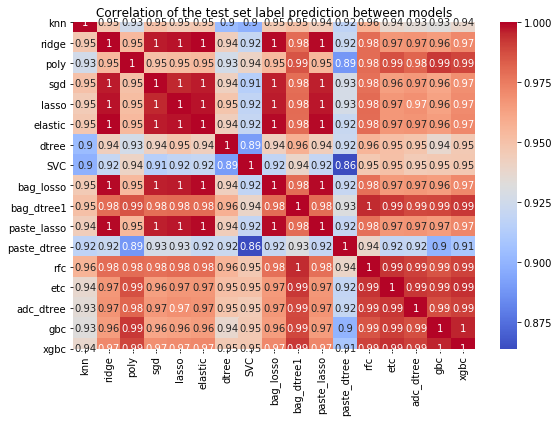

In [87]:
# Plot a heatmap of all correlations for easier visualization
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
g = sns.heatmap(pred.corr(), annot=True, cmap='coolwarm', ax=ax)
g.set_title('Correlation of the test set label prediction between models')

In [88]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=True)
    return au_corr[0:n]



In [89]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(pred, 5))

Top Absolute Correlations
SVC          paste_dtree    0.863839
poly         paste_dtree    0.888366
dtree        SVC            0.890731
knn          SVC            0.898619
paste_dtree  gbc            0.899873
dtype: float64


# Stacking

## Voting top 5

In [90]:
from sklearn.ensemble import VotingRegressor

In [172]:
vclf1 = VotingRegressor(estimators=
                              [('ridge', grid_ridge.best_estimator_),
                              ('lasso', grid_lasso.best_estimator_), 
                             ('elastic', grid_elasticnet.best_estimator_),
                               ('bag_losso', bag_lasso_grid.best_estimator_),
                               ('xgbc', xgbc_grid.best_estimator_)
                            ], )
vclf1_param = {}
vclf1_grid = GridSearchCV(vclf1, vclf1_param,cv=10, return_train_score=True, n_jobs=-1)
vclf1_grid.fit(X_train,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=VotingRegressor(estimators=[('ridge',
                                                    Ridge(alpha=100,
                                                          copy_X=True,
                                                          fit_intercept=True,
                                                          max_iter=None,
                                                          normalize=False,
                                                          random_state=None,
                                                          solver='auto',
                                                          tol=0.001)),
                                                   ('lasso',
                                                    Lasso(alpha=830,
                                                          copy_X=True,
                                                          fit_intercept=True,
                                    

In [174]:
# let's get the predictions
X_train_preds = vclf1_grid.predict(X_train)
X_test_preds = vclf1_grid.predict(X_test)


# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))
print()
print("Best parameters: {}".format(vclf1_grid.best_params_))
print("Best cross-validation score: {:.4f}".format(vclf1_grid.best_score_))

train mse: 420217879.04743093
train rmse: 20499.21654716177
train r2: 0.9326987197359007

test mse: 800126920.7373974
test rmse: 28286.514821331337
test r2: 0.8835690486316827

Best parameters: {}
Best cross-validation score: 0.8974


## Voting Least Correlated

In [128]:
vclf3 = VotingRegressor(estimators=
                              [('knn', grid_knn.best_estimator_), 
                               #('poly', grid_poly.best_estimator_), 
                               ('dtree', grid_tree.best_estimator_),
                               ('paste_dtree', paste_dtree2_grid.best_estimator_)
                              ])
vclf3_param = {}
vclf3_grid = GridSearchCV(vclf3, vclf3_param,cv=5, return_train_score=True)
vclf3_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=VotingRegressor(estimators=[('knn',
                                                    Pipeline(memory=None,
                                                             steps=[('scaler',
                                                                     MinMaxScaler(copy=True,
                                                                                  feature_range=(0,
                                                                                                 1))),
                                                                    ('knnreg',
                                                                     KNeighborsRegressor(algorithm='auto',
                                                                                         leaf_size=30,
                                                                                         metric='minkowski',
                                                          

In [168]:
# let's get the predictions
X_train_preds = vclf3_grid.predict(X_train)
X_test_preds = vclf3_grid.predict(X_test)


# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))
print()
print("Best parameters: {}".format(vclf3_grid.best_params_))
print("Best cross-validation score: {:.4f}".format(vclf3_grid.best_score_))

train mse: 832415708.5978715
train rmse: 28851.615355086647
train r2: 0.8666819150399339

test mse: 1261031293.680614
test rmse: 35511.00243136786
test r2: 0.8165002708656002

Best parameters: {}
Best cross-validation score: 0.8133


In [ ]:
pip install --upgrade scikit-learn

## Stacking Top 5

In [150]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Lasso

In [178]:
sclf1 = StackingRegressor(estimators=
                              
                              [('ridge', grid_ridge.best_estimator_),
                              ('lasso', grid_lasso.best_estimator_), 
                             ('elastic', grid_elasticnet.best_estimator_),
                               ('bag_losso', bag_lasso_grid.best_estimator_),
                               ('xgbc', xgbc_grid.best_estimator_)
                              ], final_estimator=Lasso())
sclf1_param = {
              'final_estimator__alpha' : [0.001, 0.01,10, 830, 850, 870,890, 900, 1000,1050,1100, 1150],
             # 'stack_method':['auto', 'predict_proba']
             }
sclf1_grid = GridSearchCV(sclf1, sclf1_param,cv=10, return_train_score=True, )
sclf1_grid.fit(X_train,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=StackingRegressor(cv=None,
                                         estimators=[('ridge',
                                                      Ridge(alpha=100,
                                                            copy_X=True,
                                                            fit_intercept=True,
                                                            max_iter=None,
                                                            normalize=False,
                                                            random_state=None,
                                                            solver='auto',
                                                            tol=0.001)),
                                                     ('lasso',
                                                      Lasso(alpha=830,
                                                            copy_X=True,
                                        

In [180]:
# let's get the predictions
X_train_preds = sclf1_grid.predict(X_train)
X_test_preds = sclf1_grid.predict(X_test)


# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))
print()
print("Best parameters: {}".format(sclf1_grid.best_params_))
print("Best cross-validation score: {:.4f}".format(sclf1_grid.best_score_))

train mse: 202211160.2308104
train rmse: 14220.097054197991
train r2: 0.967614252877407

test mse: 776056997.6693237
test rmse: 27857.799584125874
test r2: 0.8870715980017192

Best parameters: {'final_estimator__alpha': 0.001}
Best cross-validation score: 0.9031


## Stacking Least Correlated

In [155]:
sclf2 = StackingRegressor(estimators=
                              [('dtree', grid_tree.best_estimator_), 
                               ('paste_dtree', paste_dtree2_grid.best_estimator_), 
                                ],
                           final_estimator=
                           XGBRegressor(random_state=42,early_stopping_rounds=2,objective= 'reg:squarederror'))
sclf2_param = {
              'final_estimator__max_depth' : [2,6],
              'final_estimator__n_estimators' : [50,150],
              'final_estimator__learning_rate' : [0.1,0.6,0.8],
              'final_estimator__min_child_weight' : [1,3,7],
              'final_estimator__subsample':[0.6,0.9,1],
             #'stack_method':['auto', 'predict_proba']
             }
sclf2_grid = GridSearchCV(sclf2, sclf2_param,cv=5, return_train_score=True, )
sclf2_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=StackingRegressor(cv=None,
                                         estimators=[('dtree',
                                                      DecisionTreeRegressor(ccp_alpha=0.0,
                                                                            criterion='mse',
                                                                            max_depth=5,
                                                                            max_features=None,
                                                                            max_leaf_nodes=None,
                                                                            min_impurity_decrease=0.0,
                                                                            min_impurity_split=None,
                                                                            min_samples_leaf=1,
                                                                            min_sample

In [166]:
# let's get the predictions
X_train_preds = sclf2_grid.predict(X_train)
X_test_preds = sclf2_grid.predict(X_test)


# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))
print()
print("Best parameters: {}".format(sclf2_grid.best_params_))
print("Best cross-validation score: {:.4f}".format(sclf2_grid.best_score_))

train mse: 924397365.8195803
train rmse: 30403.903792433965
train r2: 0.8519503112684157

test mse: 1262645228.06024
test rmse: 35533.71959224421
test r2: 0.8162654182311048

Best parameters: {'final_estimator__learning_rate': 0.1, 'final_estimator__max_depth': 2, 'final_estimator__min_child_weight': 1, 'final_estimator__n_estimators': 50, 'final_estimator__subsample': 1}
Best cross-validation score: 0.7992
